# The project:

##### Submitted by Tal Rave and Assaf Goren

### The problem: face detection and clustering 

We created a program that detects, aligns and crops faces from images, and clusters them.<br><br>
A quick reminder:<br><br>
In our presentation we showed a simple program that clusters images of faces taken from a small dataset, by using simple "hand-crafted" features (e.g. HOG features) and hierarchical clustering (we used the number of individuals as input) - we took this idea a few steps forward; we used larger datasets of images taken "in-the-wild" (hence the need to detect, align and crop), and used clustering methods that are distance\density-based so that we will not need to input the number of individuals in the test sets.



### Motivation:

Given a dataset of unlabeled images of people, our algorithm will manage (to some degree) to distinguish between the detected faces and cluster them accordingly. The main use\motivation is human surveillance. Imagine having cameras spread out in many different areas\locations, which accumulate images of faces and periodically send them to some data center. Assume that (ideally) all images of a person's face are placed in a unique cluster. We know where that person was and when (where and when his\her photos were taken), and so we can get a good estimate of the exact route that that person took. It is easy to imagine how this method can be used to help law enforcement in cases where many images of people need to be analyzed quickly to capture an escaping criminal\terrorist.<br>
Another potential use we can think of is video summarization. For example, media service providers can make use of face clustering as means to obtain useful information about movies and tv series; once we have the face images of a character(actor) in a separate cluster with relevant information about each image, we can obtain information about this character (interactions with other characters, close-up levels, type of scene, screen time, etc.) - this information (along with other things, such as the movie’s genre) can later be used to make future recommendations to viewers by comparing it with information about their preferences.<br>
It should be noted that the same principles can be applied to other types of images. Therefore, there are probably many other creative applications that one might think of; an obvious example is automatic image labelling (even partially sorted images can make the manual work much easier).

### Methods:

The project is composed of 3 main parts\stages:
1. Data preparation (grayscale conversion, detection, alignment, cropping, resizing, meta-data cleaning, data balancing, etc.).<br>
2. Supervised learning (Training a CNN to generate vector representations that help distinguish between images of faces of different individuals).<br>
3. Unsupervised learning (clustering the image representations that were generated in the previous stage).

We used the following methods:<br><br>
Stage 1:<br><br>
Convert to grayscale, use Viola-Jones algorithm to detect faces, detect eyes
in the face rectangle (also using Viola-Jones), align the face by rotating the image about the midpoint of the eye rectangles' centers by the appropriate angle, crop the face and resize it to a predetermined size.<br><br>
Stage 2:<br><br>
We implemented a CNN that receives a face image as input, and outputs a point in n-dimensional space such that face images of the same person would be transformed into points that are near each other and far from all points that are derived from face images of other individuals - this makes clustering much more effective.<br>
Initially, we implemented a CNN that is trained by feeding it with triplets of face images (using the triplet loss function - you can read about it here https://en.wikipedia.org/wiki/Triplet_loss). We got decent results, but not completely satisfactory; our goal was to reach an F1 score (see https://en.wikipedia.org/wiki/F1_score) of at least 0.9 on the third (small) dataset (the F1 score is calculated over all the possible pairs of images; if a pair of images of the same person end up in the same cluster, then it is considered a true positive, etc.; you can check the exact calculation in the relevant code segment); we got close but not quite. Instead, we used a different strategy and got much better results; we simply connected a large dense "softmax" layer to the last layer of the inner part of our first network and trained it to do classification over the set of individuals (now, the input during training is just a single image). Then, we used the outputs of the previous layer as the new image representations (we will elaborate on this going forward). <br><br>
Stage 3:<br><br>
We used DBSCAN clustering algorithm, since we assume that the exact number of individuals\clusters is unknown. Additionally, we used t-SNE on the feature vectors returned by the CNN and applied the clustering algorithm on its output - this makes clustering easier because we can actually see the potential clusters (easier to pick a useful epsilon value for DBSCAN).<br><br>

### Data:

We used the following datasets:<br>

1. http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html (The non-aligned version).
2. http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/ (This is an exceptionally large dataset).
3. https://scikit-learn.org/0.19/datasets/olivetti_faces.html (This is the small dataset that we used in the presentation).<br>

Initially, we tried to train the first network on the images derived from the first dataset; we managed to extract around 80,000 faces out of around 200,000 images. Unfortunately, the average number of images per person was quite low (~9), and the network was not able to achieve satisfactory results (F1 score < 0.8 on the third dataset). Therefore, we decided to extract faces from the second dataset. We managed to extract ~700,000 faces out of ~3,000,000 images. We have lost a lot of data, but our goal was to extract only ~100,000 images of men and ~100,000 images of women, such that each of these two sets will have a few dozens of images per person (any more than that would have taken too long for our hardware to process). Clearly, the detection algorithm we used (Viola-Jones) had a hard time detecting some faces due to varying degrees of rotation, viewpoints, and even certain facial expressions. However, the resultant normalized faces were well cropped and aligned (we found only ~60 improperly cropped images out of ~80,000 in the first normalized dataset, and so there was generally no need to manually look for and  remove such images from the larger derived dataset). Another problem we encountered - the derived datasets were no longer as balanced as the originals (a lot more men than women, the average number of images for women was much greater, some individuals had a lot of images and others had almost none, etc.). As we implied, there is a meta-data file available on the site that contains gender information, and so we were able to correct the imbalance. Eventually, we combined the training and test sets of the second dataset and used the first and third datasets as test sets (the first dataset is large, contains an unequal amount of images per person and more images of women, and the third is small, contains more images of men, and has an equal number of images per person). In the end, although we ended up with a bigger and more balanced dataset, our first network could not reach the desired score (it did show some improvement, however). As a result, we decided to try the different strategy that we mentioned previously.

### First, let us import everything we need and define some auxiliary methods:

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from sklearn import datasets, cluster
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import seaborn as sns; sns.set()
import sys
import cv2
from keras_facenet import FaceNet
import pandas as pd
import shutil

# these are the paths where the data is expected to be:
startPath = "E:\\" # all the folders and files should be here
celebaPath = startPath+"celeb\\img_celeba" # the first original dataset
celebaNormPath = startPath+"celeb\\img_celebaNorm" # the first dataset after normalization
celebaIdPath = startPath+"celeb\\identity_CelebA.txt" # the identities of the first dataset
celebaBadCrops = startPath+"celeb\\badCrops.jpg" # example image of improperly cropped faces
vggPath = startPath+"vggface2" # the second original dataset (devided into train and test folders)
vggTrainPath = vggPath+"\\train" # the train folder
vggTestPath = vggPath+"\\test" # the test folder
vggNormPath = vggPath+"\\vggNorm" # the second dataset after normalization
vggIdPath = vggPath+"\\id.csv" # the identities and genders of the second dataset
vggBadId = vggPath+"\\id.jpg" # cleaning example
cleanedDataPath = vggPath+"\\vggClean" # the second dataset after cleaning\balancing

normImgSize = (64,64) # this is the size of the normalized images that we use

# prints over the previous line
def printOverLine(s):
    sys.stdout.write(s)  
    sys.stdout.write('\r')
    sys.stdout.flush()
    
# lists folders and files
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        r.append((root, dirs, files))
    return r

# normalizes images in location inPath and writes the result to location outPath
def writeImages(inPath, outPath):
    try:
        os.mkdir(outPath)
    except:
        pass # we assume it's there already
    f = list_files(inPath)
    folders = f[0][1]
    for fld in folders:
        try:
            os.mkdir(outPath+"\\"+fld)
        except:
            pass
    processed = written = 0
    for i in range(len(folders)):
        curFolderImgFiles = f[i+1][2]
        for c in curFolderImgFiles:
            img = cv2.imread(f[i+1][0]+"\\"+c)
            processed+=1
            normImg = normalizeImage(img, normImgSize)
            if normImg is not None:
                cv2.imwrite(outPath+"\\"+folders[i]+"\\"+c, normImg)
                written+=1
            printOverLine("Processing folder "+folders[i]+". Images processed\written: "+str(processed)+"\\"+str(written))
    print('\nDone!') 

# this method visualizes 2D points with different color and text for each class
def visClustering(data, labels, title, text=True):
    palette = sns.color_palette("hls", len(set(labels)))
    colorMap = {l : [c] for l, c in zip(set(labels), palette)} # map labels to colors
    colorMap[-1] = [(0.5,0.5,0.5)] # gray color for outliers
    fig = plt.figure(figsize=(15,15))
    for i, (x, y, t) in enumerate(zip(data[:,:1], data[:,1:], labels)):
        plt.scatter(x, y, c=colorMap[t], s=50)
        if i % 2 == 0 and text == True: # prevents text clutter
            plt.text(x, y, t, fontsize=12)
    plt.title(title, fontsize=32)
    plt.axis('off')
    print()
    plt.show()
    
# calculates and returns the F1 score of the predicted clustering
def F1Score(trueLabels, predictedLabels):
    # for every combination of 2 images:
    # same person, same cluter = TP
    # same person, different cluster = FN
    # diff person, same cluster = FP
    # diff person, diff cluster = TN
    P=N=TP=TN=FP=FN=0
    for i in range(len(predictedLabels)): 
        for j in range(i+1, len(predictedLabels)):
            if trueLabels[i] == trueLabels[j]:
                P+=1
                if predictedLabels[i] == predictedLabels[j] and predictedLabels[i] != -1: # -1 = outlier (a cluster of size 1)
                    TP+=1
                else:
                    FN+=1
            else:
                N+=1
                if predictedLabels[i] == predictedLabels[j] and predictedLabels[i] != -1:
                    FP+=1
                else:
                    TN+=1
                    
    if TP+FP == 0 or P == 0:
        return None
    pre = TP/(TP+FP)
    sen = TP/P
    if pre+sen == 0:
        return None
    F1 = 2*pre*sen/(pre+sen)
    return F1

# draws images in rows of 10 (max)
def drawTenPerRow(imgs):
    x = 10-len(imgs)%10+len(imgs) # how many rows?
    plt.figure(figsize=(10, x//10))
    for i in range(x):
        for j in range(10):
            if 10*i+j >= len(imgs): # no more images to draw
                break
            plt.subplot(x//10, 10, 10*i+j+1)
            plt.imshow(imgs[10*i+j], cmap='gray')
            plt.axis('off') 
    plt.show()

# draws the images (according to their clustered 2D points)   
def drawClusteredImages(predictedLabels, images):
    imgsMap = {}
    outliers = []
    # map labels to images according to the predicted clusters
    for i in range(len(predictedLabels)):
        if predictedLabels[i] != -1:
            try:
                imgsMap[predictedLabels[i]].append(images[i])
            except:
                imgsMap[predictedLabels[i]] = []
                imgsMap[predictedLabels[i]].append(images[i])
        else: # place outliers in a seperate list
            outliers.append(images[i])
    print()
    
    # draw the images of the predicted clusters
    for k in sorted(list(imgsMap.keys())):
        print("Cluster "+str(k)+":")
        drawTenPerRow(imgsMap[k])  

    if len(outliers) > 0:
        # draw the outlier images
        print("Outliers: "+str(len([x for x in predictedLabels if x == -1]))+" out of "+str(len(predictedLabels)))
        drawTenPerRow(outliers)
    else:
        print("No outliers!")  

# splits data to training and test sets
def splitTrainTest(data, testPercentage):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    # for each label:
    for i in range(len(data)):
        # how many to put in training set for the current label?
        p = int(len(data[i])-testPercentage/100*len(data[i]))
        for j in range(p):
            x_train.append(data[i][j])
            y_train.append(i)
        for j in range(p, len(data[i])):
            x_test.append(data[i][j])
            y_test.append(i)
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

## Stage 1 (data preparation):

### This method detects a face in an image and returns a normalized version:

In [18]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# This method receives an image of a person, and returns 
# a normalized version (converts to grayscale, detects the face and eyes, aligns using the eyes center points, 
# crops the face and resizes to the size given as input)
def normalizeImage(img, size, returnSteps=False):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face1 = face_cascade.detectMultiScale(img, 1.3, 5) # detect face
    if len(face1) != 1: # we expect to detect exactly one face per image
        return None
    (x,y,w,h) = face1[0]
    roi = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi, 1.3, 5) # detect the eyes
    ePts = [np.array([x+ex+ew/2,y+ey+eh/2]) for (ex,ey,ew,eh) in eyes]
    if len(ePts) != 2: # we expect to detect exactly two eyes
        return None
    if ePts[0][0] > ePts[1][0]: # make sure that the left eye center is the first point
        ePts[0], ePts[1] = ePts[1], ePts[0]
    v = (ePts[1]-ePts[0]) # calc the vector given by the eye centers
    if v[0] == 0:
        return None
    ang = np.arctan2(v[1], v[0])*180/np.pi # calc angle between v and the x axis
    eyeCenter = tuple(0.5*ePts[0] + 0.5*ePts[1]) # calc the midpoint of the centers
    rotMat = cv2.getRotationMatrix2D(eyeCenter, ang, 1.0)
    rotated = cv2.warpAffine(img, rotMat, img.shape[1::-1])
    face2 = face_cascade.detectMultiScale(rotated, 1.3, 5) # find the face again after rotating the image
    if len(face2) != 1: # we might fail to find it a second time
        return None
    (x,y,w,h) = face2[0]
    cropped = rotated[y:y+h, x:x+w]
    resized = cv2.resize(cropped,None,fx=size[0]/w, fy=size[1]/h)
    if returnSteps == False:
        return resized
    else:  
        return face1, eyes, rotated, face2, resized # we need these for display

### Let us see how it works:

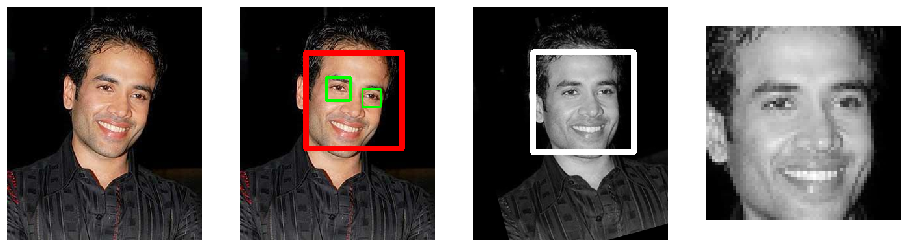

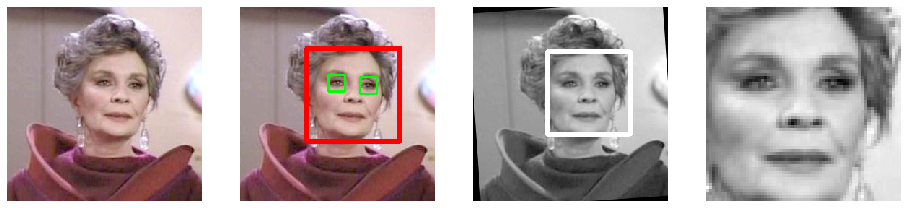

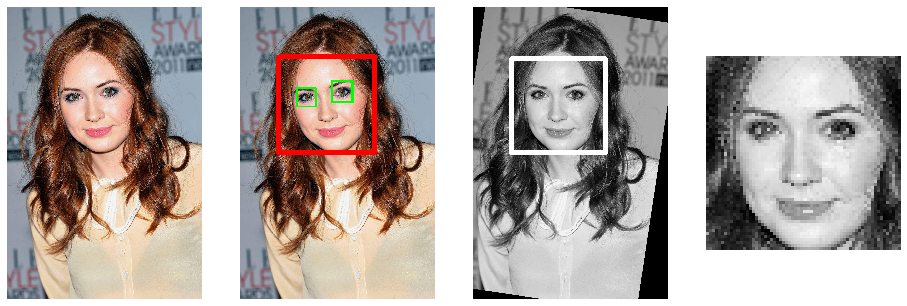

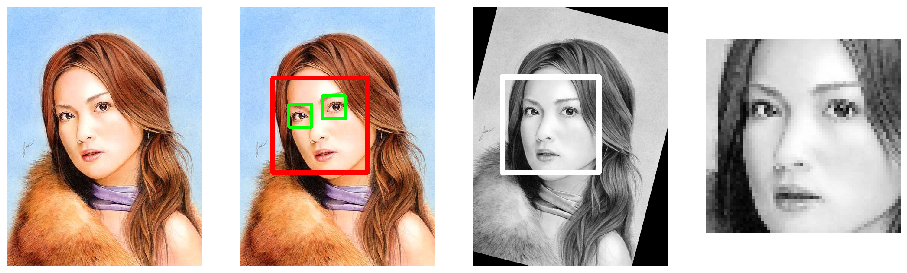

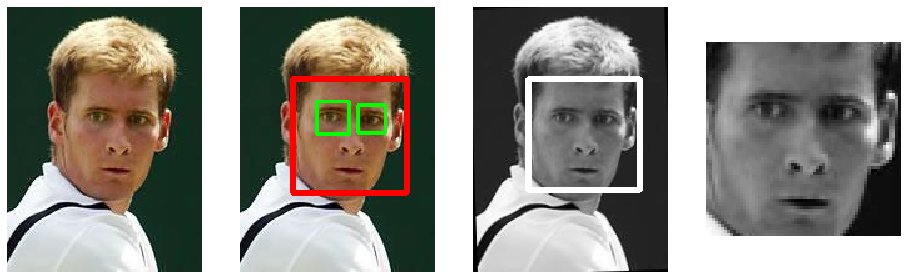

In [19]:
# normalize some images and draw the results
for i in range(80,90):
    img = cv2.imread(celebaPath+"\\imgs\\"+str(i+1).zfill(6)+'.jpg')
    before = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    after = normalizeImage(img, normImgSize, returnSteps=True)
    if after is not None:
        
        # show original
        plt.figure(figsize=(16,4*16))
        plt.subplot(4*2, 4, 1)
        plt.imshow(before)
        plt.axis('off')
        
        # show detected face and eyes
        face1, eyes, rotated, face2, resized = after     
        (x,y,w,h) = face1[0]
        roi = before[y:y+h,x:x+w]
        before = cv2.rectangle(before, (x,y), (x+w,y+h), (255,0,0), w//20)
        (x,y,w,h) = eyes[0]
        roi = cv2.rectangle(roi, (x,y), (x+w,y+h), (0,255,0), w//10)
        (x,y,w,h) = eyes[1]
        roi = cv2.rectangle(roi, (x,y), (x+w,y+h), (0,255,0), w//10)
        plt.subplot(4*2, 4, 2)
        plt.imshow(before)
        plt.axis('off')
        
        # show detected face after rotating
        (x,y,w,h) = face2[0]
        roi = before[y:y+h,x:x+w]
        rotated = cv2.rectangle(rotated, (x,y), (x+w,y+h), (255,0,0), w//20)
        plt.subplot(4*2, 4, 3)
        plt.imshow(rotated, cmap='gray')
        plt.axis('off')
        
        # show the final result (cropped and resized)
        plt.subplot(4*2, 4, 4)
        plt.imshow(resized, cmap='gray')
        plt.axis('off')
        plt.show();

The algorithm failed to detect some faces, but the results are quite good.

### Normalize all the images of the first dataset and write the results:

In [20]:
try:
    writeImages(celebaPath, celebaNormPath)
except KeyboardInterrupt:
    print("\n\nStopped!")

Images processed\written: 202599\87199
Done!


### Display the improperly cropped images of the first dataset:

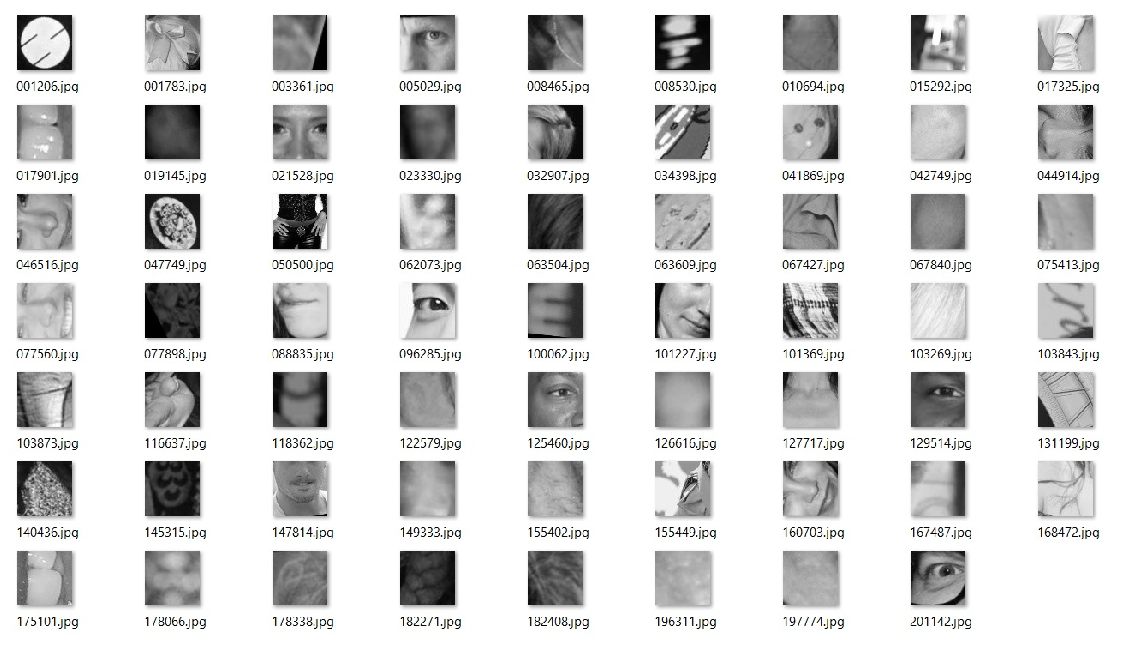

In [21]:
img = cv2.cvtColor(cv2.imread(celebaBadCrops), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,40))
plt.axis('off')
plt.imshow(img);

As we said, very few images were improperly cropped.

### Normalize all the images of the second dataset and write the results:

In [22]:
try:
    writeImages(vggTrainPath, vggNormPath)
    writeImages(vggTestPath, vggNormPath)
except KeyboardInterrupt:
    print("\n\nStopped!")

Processing folder n009279. Images processed\written: 3141890\640229
Done!
Processing folder n009294. Images processed\written: 169396\32272
Done!


### Examine the meta-data file (see "identity_meta.csv" file):

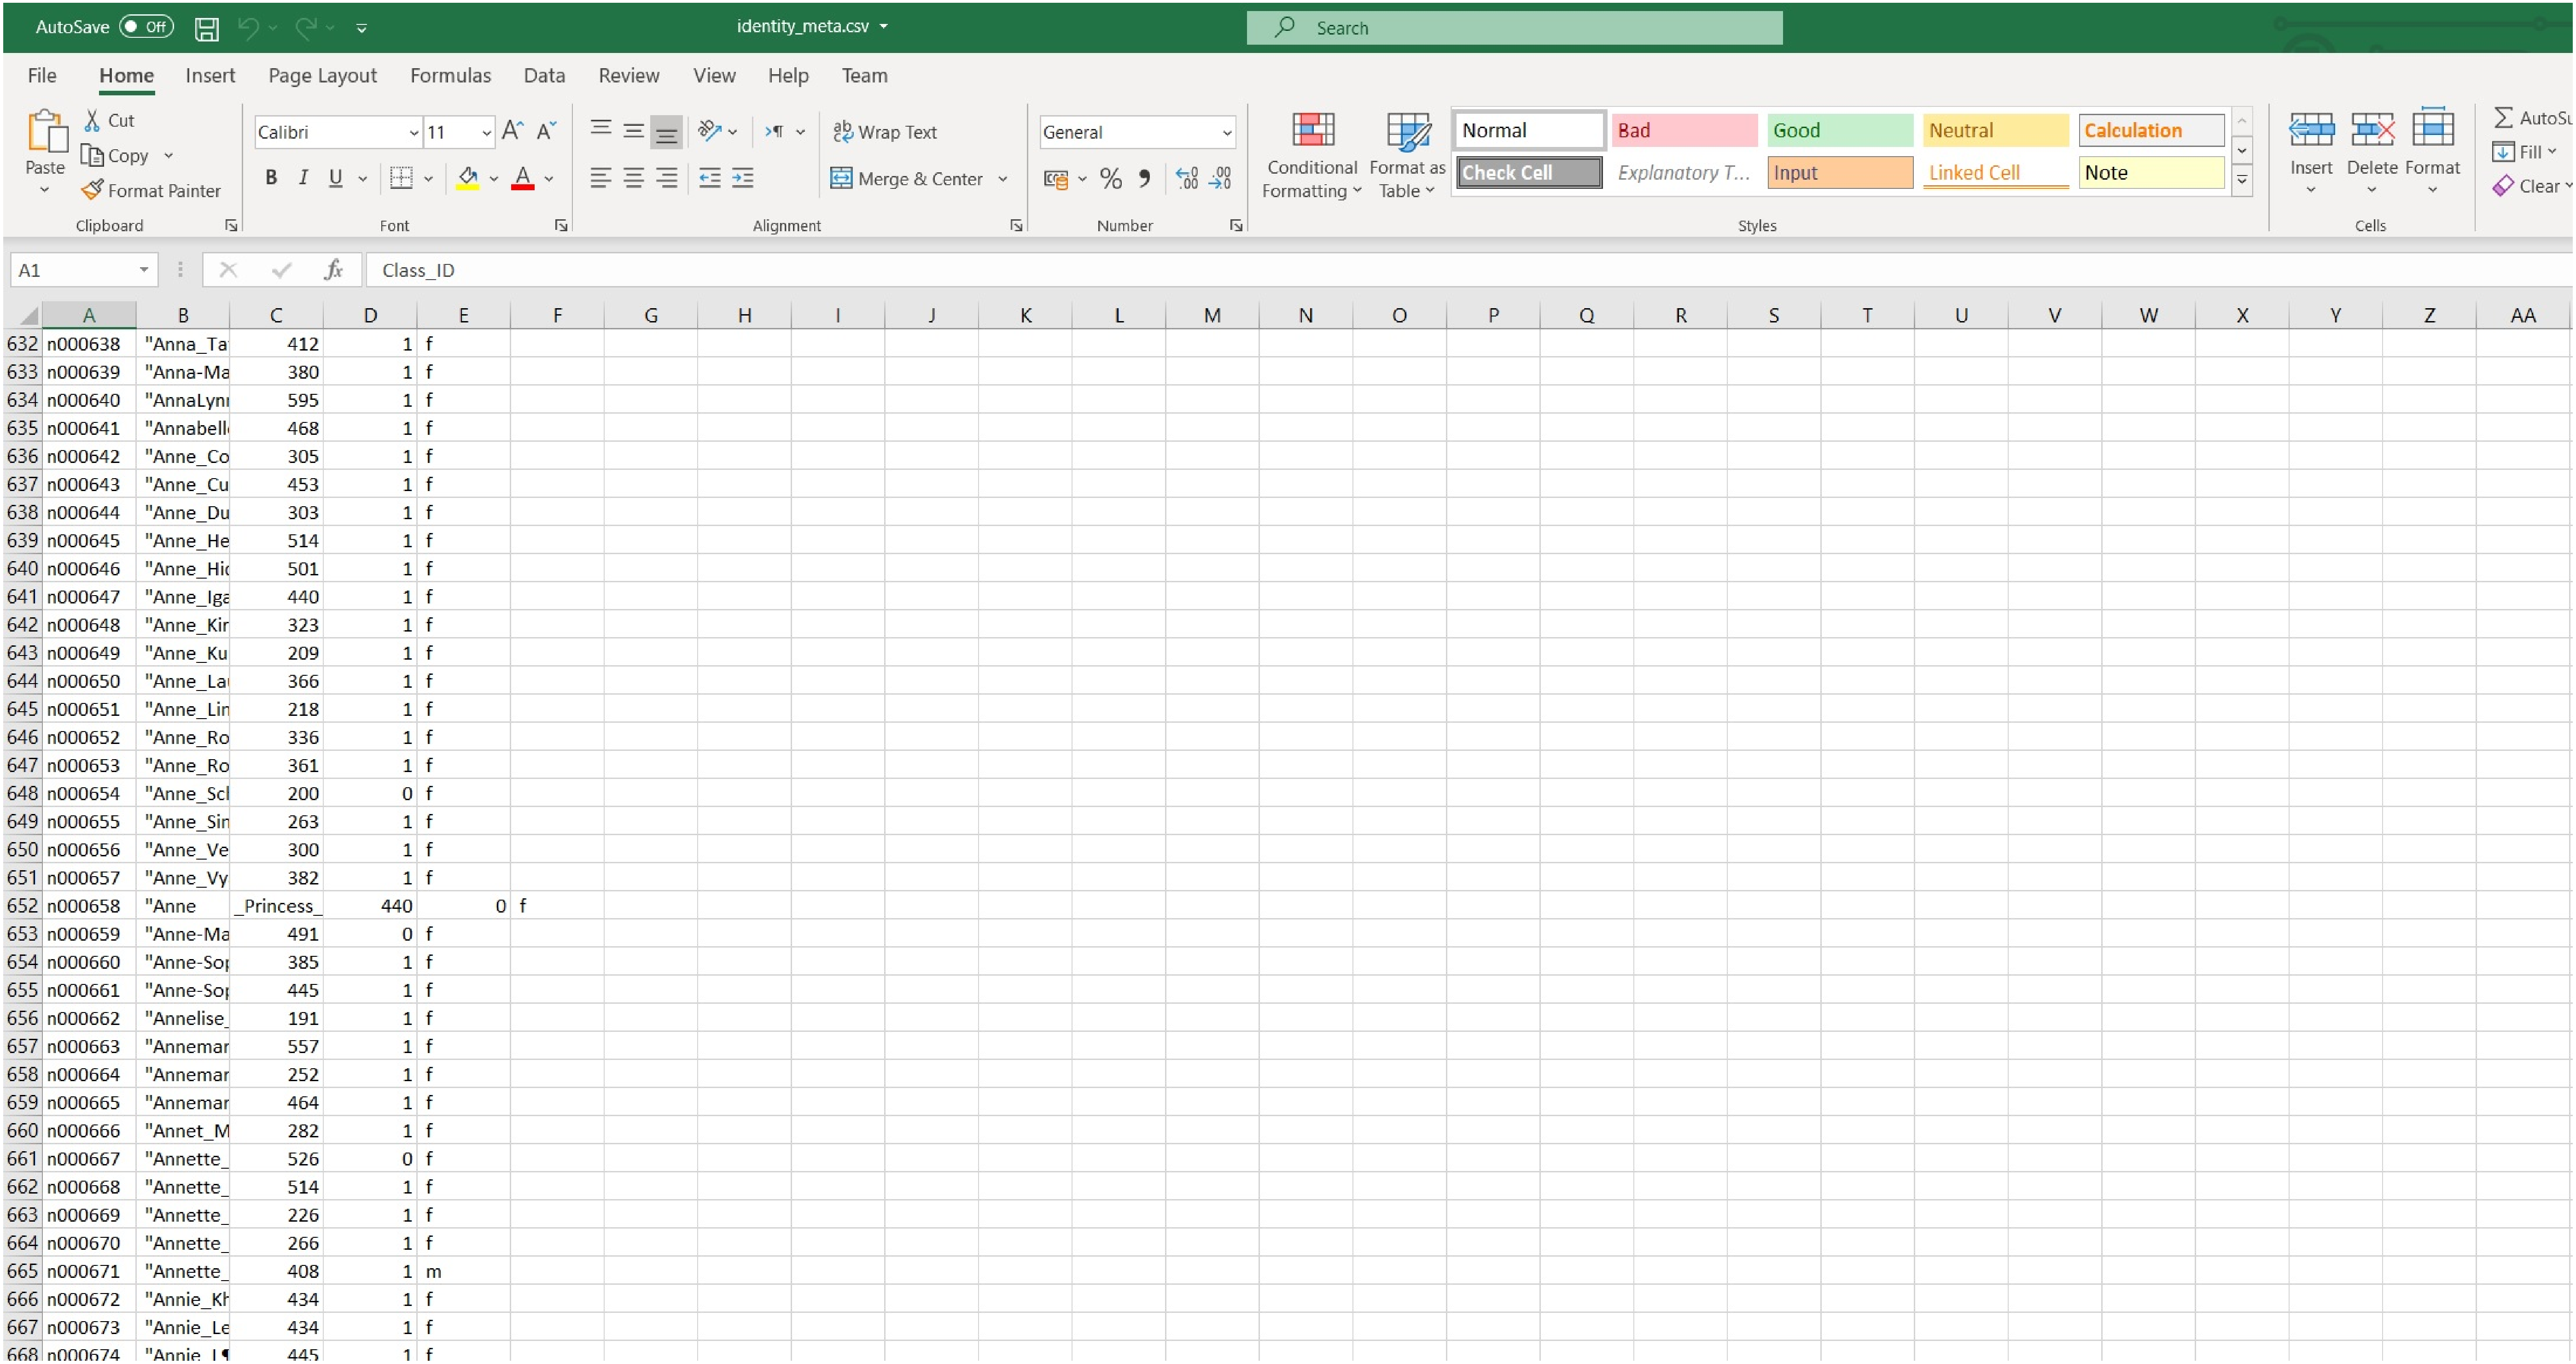

In [23]:
img = cv2.cvtColor(cv2.imread(vggBadId), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(100,100))
plt.axis('off')
plt.imshow(img);

As we can see, the meta-data file is "dirty"; some of the names contain commas - as a result of that, we will not be able to load the file using "pandas" since the rows are uneven. To deal with this, we used Excel's “CONCAT” function to concatenate the gender column with the flag (whether the person belongs to the training\test set) column. Then, we used Excel's “SUBSTITUTE” function to remove the flag character (there were also spaces that needed to be removed). Finally, we removed all the irrelevant columns (we are only interested in the folder name and gender attributes).

### Load the meta-data file:

In [3]:
df = pd.read_csv(vggIdPath)
f = list_files(vggNormPath)
folders = f[0][1]
imgs = []
for i in range(len(folders)):
    imgs.append(f[i+1][2])
df['imgs'] = imgs # for each person, append his\her list of images
males = df[df['Gender'] == 'm']
females = df[df['Gender'] == 'f']
display(males)
display(females)

Class_ID Gender                                               imgs
0     n000001      m            [0386_01.jpg, 0391_01.jpg, 0407_01.jpg]
2     n000003      m  [0001_01.jpg, 0008_01.jpg, 0012_01.jpg, 0014_0...
3     n000004      m  [0005_01.jpg, 0014_01.jpg, 0020_01.jpg, 0024_0...
4     n000005      m  [0002_01.jpg, 0003_01.jpg, 0006_01.jpg, 0008_0...
5     n000006      m  [0001_01.jpg, 0002_02.jpg, 0003_01.jpg, 0008_0...
...       ...    ...                                                ...
9115  n009272      m  [0015_01.jpg, 0026_01.jpg, 0029_01.jpg, 0032_0...
9117  n009274      m  [0001_01.jpg, 0002_01.jpg, 0003_01.jpg, 0004_0...
9120  n009277      m  [0003_01.jpg, 0004_01.jpg, 0006_01.jpg, 0007_0...
9123  n009283      m  [0022_01.jpg, 0024_01.jpg, 0043_01.jpg, 0046_0...
9129  n009291      m  [0002_01.jpg, 0003_01.jpg, 0005_01.jpg, 0005_0...

[5452 rows x 3 columns]

Class_ID Gender                                               imgs
1     n000002      f  [0002_01.jpg, 0003_01.jpg, 0006_01.jpg, 0008_0...
8     n000009      f  [0006_01.jpg, 0073_01.jpg, 0103_01.jpg, 0106_0...
9     n000010      f  [0001_01.jpg, 0002_01.jpg, 0003_01.jpg, 0004_0...
10    n000011      f  [0001_01.jpg, 0002_01.jpg, 0003_01.jpg, 0004_0...
21    n000022      f  [0001_01.jpg, 0002_01.jpg, 0003_01.jpg, 0005_0...
...       ...    ...                                                ...
9125  n009286      f  [0002_02.jpg, 0002_03.jpg, 0003_02.jpg, 0004_0...
9126  n009287      f  [0002_01.jpg, 0003_01.jpg, 0003_02.jpg, 0017_0...
9127  n009288      f  [0004_01.jpg, 0006_01.jpg, 0012_01.jpg, 0014_0...
9128  n009289      f  [0005_01.jpg, 0005_02.jpg, 0010_01.jpg, 0013_0...
9130  n009294      f  [0003_01.jpg, 0004_01.jpg, 0023_01.jpg, 0049_0...

[3679 rows x 3 columns]

### This method prints some statistics derived from the cleaned meta-data file (see "id.csv" file):


Number of males: 5452
Total number of male images: 280891
Average number of images per male: 51.520726338958184

Number of Females: 3679
Total number of female images: 391610
Average number of images per female:  106.44468605599347


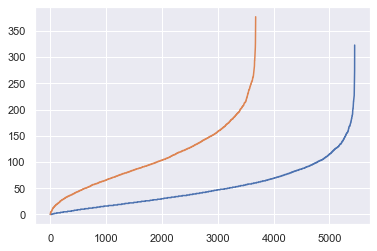

In [4]:
def stats():
    print("\nNumber of males: "+str(len(males)))
    print("Total number of male images: "+str(males['imgs'].apply(len).sum()))
    print("Average number of images per male: "+str(males['imgs'].apply(len).mean()))
    print("\nNumber of Females: "+str(len(females)))
    print("Total number of female images: "+str(females['imgs'].apply(len).sum()))
    print("Average number of images per female:  "+str(females['imgs'].apply(len).mean()))
    males['imgs'].apply(len).sort_values().plot(label="males", use_index=False);
    females['imgs'].apply(len).sort_values().plot(label="females", use_index=False);

stats()

The x axis is the individuals' numbers and the y axis is the number of images the individuals' have. As we said, the normalized image data is quite unbalanced.

### Balance the normalized image data: 


Number of males: 3536
Total number of male images: 228446
Average number of images per male: 64.60576923076923

Number of Females: 3538
Total number of female images: 229698
Average number of images per female:  64.9231204070096


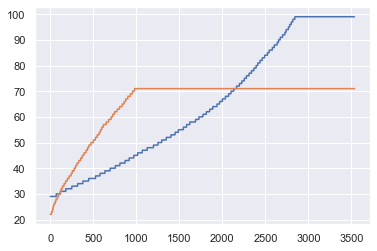

In [5]:
# set minimums and maximums for the number of images per male\female
minMaleImgs = 29
maxMaleImgs = 99
minFemaleImgs = 22
maxFemaleImgs = 71

# get those who have enough images
males = males[males['imgs'].apply(len) >= minMaleImgs]
females = females[females['imgs'].apply(len) >= minFemaleImgs]

# remove images of those who have too many
for row in males.iterrows():
    row[1][2] = row[1][2][:maxMaleImgs]  
for row in females.iterrows():
    row[1][2] = row[1][2][:maxFemaleImgs]    

# let's see what we're getting now
stats()

We removed individuals that have a small amount of images and images of individuals that have too many images in such a way that the number of men and women would be equal, and the average number of images per person would also be equal for both men and women. However, there is still an imbalance in the number of images per person in general. We can see that keeping exactly 30 images of each person would provide us with a well-balanced dataset.


Number of males: 3467
Total number of male images: 104010
Average number of images per male: 30.0

Number of Females: 3441
Total number of female images: 103230
Average number of images per female:  30.0


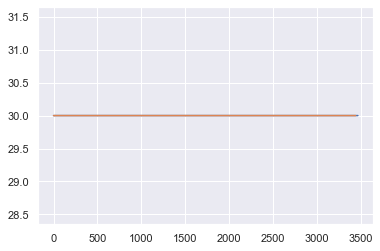

In [6]:
# set minimums and maximums for the number of images per male\female
minMaleImgs = 30
maxMaleImgs = 30
minFemaleImgs = 30
maxFemaleImgs = 30

# get those who have enough images
males = males[males['imgs'].apply(len) >= minMaleImgs]
females = females[females['imgs'].apply(len) >= minFemaleImgs]

# remove images of those who have too many
for row in males.iterrows():
    row[1][2] = row[1][2][:maxMaleImgs]  
for row in females.iterrows():
    row[1][2] = row[1][2][:maxFemaleImgs]    

# let's see what we're getting now
stats()

Just what we wanted.

### Copy the selected images to a new folder:

In [7]:
try:
    joined = pd.concat([males, females])
    written=0
    try:
        os.mkdir(cleanedDataPath)
    except:
        pass
    for row in joined.iterrows():
        fld = row[1][0]
        try:
            os.mkdir(cleanedDataPath+"\\"+fld)
        except:
            pass
        for file in row[1][2]: 
            shutil.copy(vggNormPath+"\\"+fld+"\\"+file, cleanedDataPath+"\\"+fld)
            written+=1
            printOverLine("Writing folder: "+fld+" Files written: "+str(written))
    print("\nDone!")    
except KeyboardInterrupt:
    print("\n\nStopped!")

Writing folder: n009294 Files written: 207240
Done!


### Load the first dataset:

In [3]:
def readAndOrganizeCelebaData(path):
    # map ids to image numbers
    idMap = {}
    with open(celebaIdPath, "r") as f:
        lines = f.readlines()
        for l in lines:
            s = l.split()
            try: 
                idMap[s[1]].append(s[0])
            except:
                idMap[s[1]] = []
                idMap[s[1]].append(s[0])
    
    # map only existing ids to existing images
    imgMap = {}
    read=0
    f = list_files(path)
    print("Reading "+str(len(f[0][2]))+" images:") 
    for k in idMap.keys():
        for j in range(len(idMap[k])):
            img = cv2.imread(path+"\\"+idMap[k][j], cv2.IMREAD_GRAYSCALE)
            if img is not None: # does this image exist?
                read+=1
                try: # normalize, expand, and then append
                    imgMap[k].append(np.expand_dims(img.astype("float32")/255, -1))
                except:
                    imgMap[k] = []
                    imgMap[k].append(np.expand_dims(img.astype("float32")/255, -1))
                if read % 100 == 0: # do not print too fast to prevent error
                    printOverLine("Images read: "+str(read))
    
    # transfrom imgMap to a list of lists
    imgs = []
    for i, k in enumerate(imgMap.keys()):
        imgs.append([])
        for j in range(len(imgMap[k])):
            imgs[i].append(imgMap[k][j])
    print("Images read: "+str(read)+"\nDone!")
    return imgs

try:
    celebaData = readAndOrganizeCelebaData(celebaNormPath+"\\imgs")
except KeyboardInterrupt:
    print("\n\nStopped!")

Reading 87199 images:
Images read: 87199
Done!


### Load the second dataset:

In [4]:
def readAndOrganizeVggData(path):
    f = list_files(path)
    folders = f[0][1] 
    imgs = []
    numImgs = 0
    read = 0
    for i in range(len(folders)):
        numImgs+=len(f[i+1][2])
    print("Reading "+str(numImgs)+" images:")  
    for i in range(len(folders)):
        curFolderImgFiles = f[i+1][2]
        imgs.append([])
        for c in curFolderImgFiles:
            img = cv2.imread(f[i+1][0]+"\\"+c, cv2.IMREAD_GRAYSCALE)
            read+=1
            imgs[i].append(np.expand_dims(img.astype("float32")/255, -1))
            if read % 100 == 0:
                printOverLine("Images read: "+str(read)) 
    print("Images read: "+str(read)+"\nDone!")  
    return imgs

try:
    vggData = readAndOrganizeVggData(cleanedDataPath)
except KeyboardInterrupt:
    print("\n\nStopped!")

Reading 207240 images:
Images read: 207240
Done!


### Load the third dataset:

In [5]:
faces = datasets.fetch_olivetti_faces()

## Stage 2 (supervised learning):

### The CNN model:

In [7]:
x = inputs = Input(shape=vggData[0][0].shape)

for i in range(3): # how deep?
    for j in range(3): # how many conv2d layers?
        x = layers.Conv2D(2**i*32, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(512)(x) # this is the feature vector
x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(vggData), activation="softmax")(x) # a neuron for each person

model = Model(inputs, outputs)

### Display and compile the network:

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496 

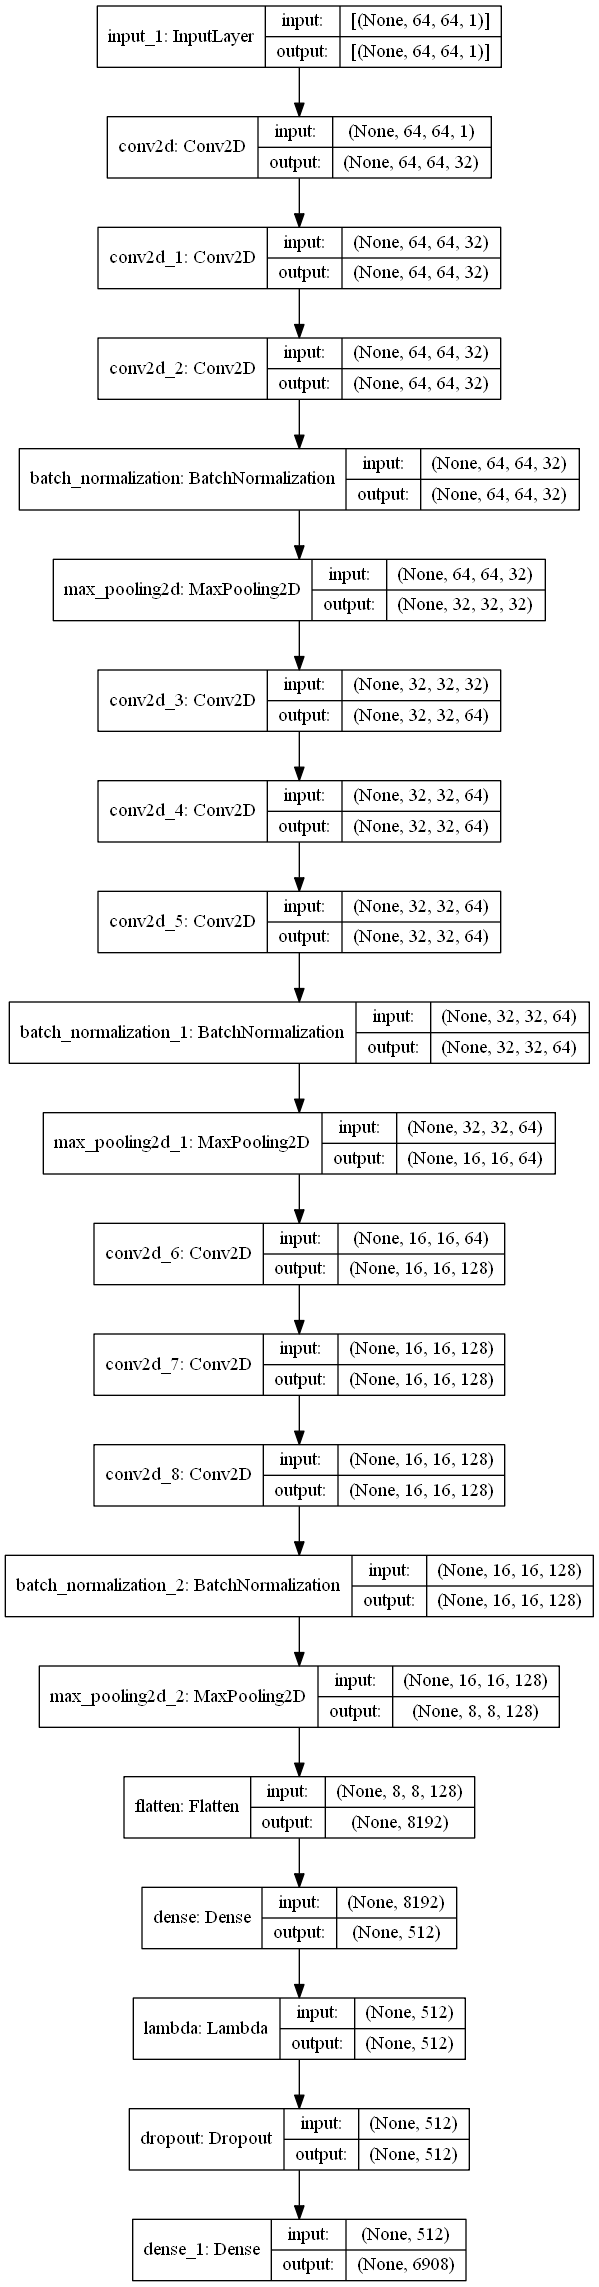

In [33]:
model.summary()
display(keras.utils.plot_model(model, show_shapes=True))
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

### The reasoning\intuition behind the aforementioned model:

We needed a model that is complex\deep enough to achieve good results, but simple enough to learn relatively quickly using our limited hardware.<br>
Essentially, our model is composed of the following basic component:
1.	Stacked convolutions with a small kernel size (Stacked convolutions enable learning non-linear\complex features before downsampling. We chose a small kernel size because our images are relatively small).
2.	Batch normalization (this can help speed up learning and improve the performance of the network in general).
3.	Max pooling (the image is downsampled to reduce the number of parameters).<br>

After flattening, we added a wide dense layer (this outputs the desired feature vectors\points) - it makes it easier to keep clusters far from one another. The L2 normalization layer is needed to make sure that the points lie on the surface of a unit hypersphere, so that the feature vectors of different persons would differ significantly in direction rather than magnitude - this helps prevent the network from interpreting noise, such as different illumination levels, as distinguishing features. We added a dropout layer before the last dense layer for some regularization. The last "softmax" layer has the same number of neurons as individuals in the dataset.

### Train the network:

In [34]:
x_train, y_train, x_test, y_test = splitTrainTest(data=vggData, testPercentage=10)

try:
    history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_test, y_test))
except KeyboardInterrupt:
    print("\n\nStopped!")

Train on 186516 samples, validate on 20724 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
186516/186516 [==============================] - 178s 957us/sample - loss: 8.3281 - acc: 0.0029 - val_loss: 7.7405 - val_acc: 0.0139
Epoch 2/20
186516/186516 [==============================] - 177s 948us/sample - loss: 7.1388 - acc: 0.0585 - val_loss: 6.8107 - val_acc: 0.1059
Epoch 3/20
186516/186516 [==============================] - 177s 950us/sample - loss: 6.0469 - acc: 0.2435 - val_loss: 5.8167 - val_acc: 0.3029
Epoch 4/20
186516/186516 [==============================] - 179s 961us/sample - loss: 5.0316 - acc: 0.4688 - val_loss: 4.9456 - val_acc: 0.4581
Epoch 5/20
186516/186516 [==============================] - 184s 987us/sample - loss: 4.1046 - acc: 0.6465 - val_loss: 4.2244 - val_acc: 0.5635
Epoch 6/20
186516/186516 [==============================] - 184s 985us/sample - loss: 3.2701 - acc: 0.7667 - val_loss: 3.4867 - val_acc

### Loss plot (training and validation loss):

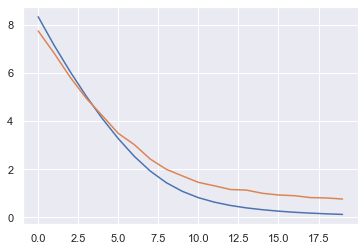

In [35]:
plt.plot(range(len(history.history['loss'])), history.history['loss']);
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss']);

### Accuracy plot (training and validation accuracy):

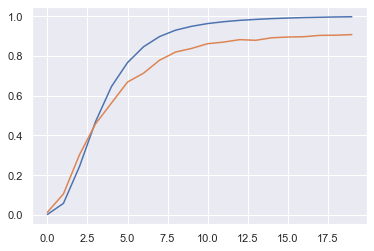

In [36]:
plt.plot(range(len(history.history['acc'])), history.history['acc']);
plt.plot(range(len(history.history['val_acc'])), history.history['val_acc']);

We do not really care about the model's ability to recognize familiar faces so we simply skip to the clustering stage (technically, we could have forgone splitting the data and have more data to train on this way, but we wanted to show that the training process is working as expected by examining the validation loss\accuracy).

### Remove the no longer needed layers to get the desired feature embedder:

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1849

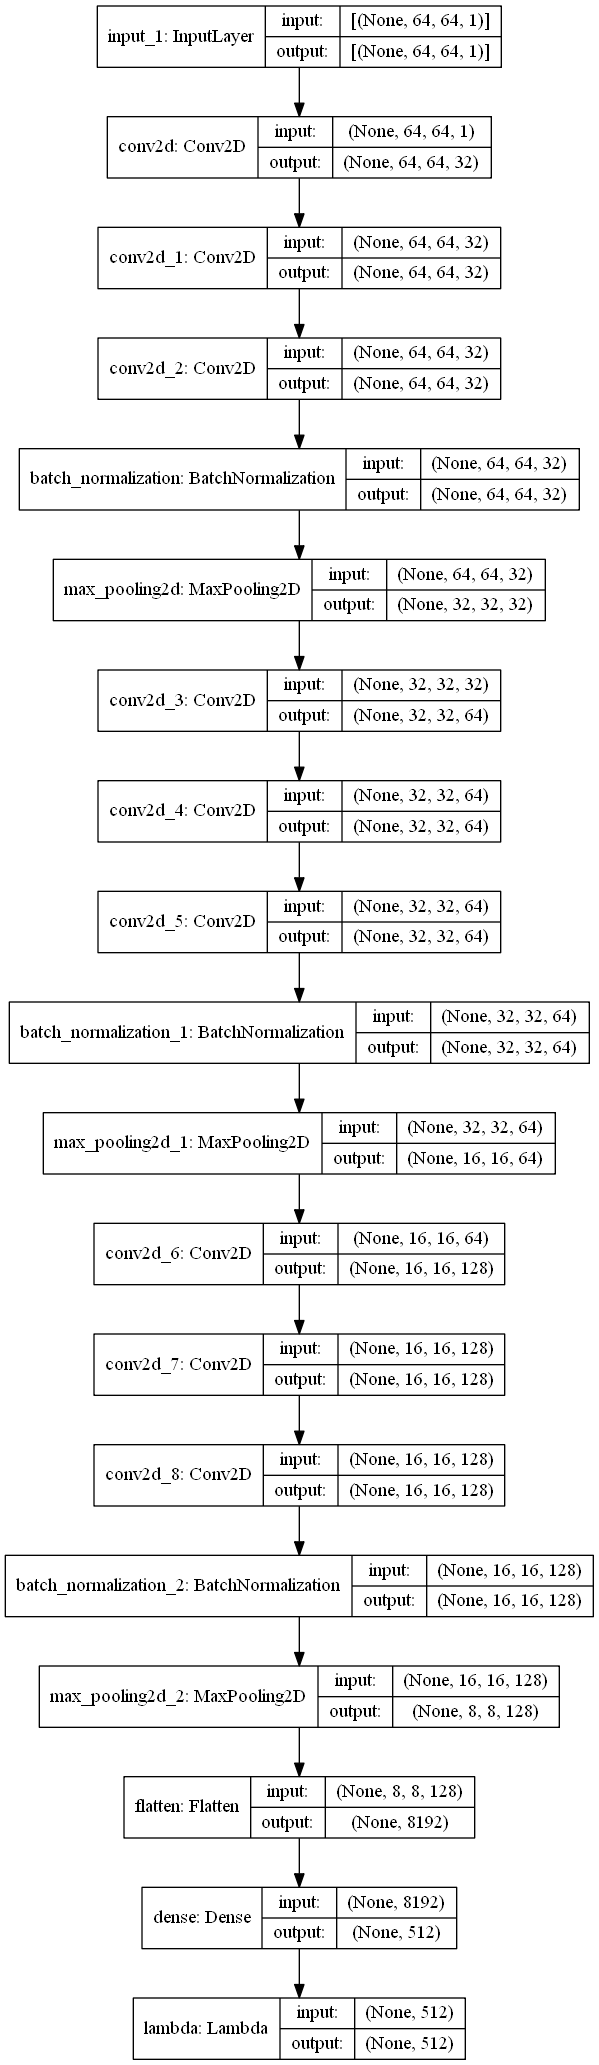

In [10]:
embedder = Model(inputs=model.inputs, outputs=model.layers[-3].output)
embedder.summary()
display(keras.utils.plot_model(embedder, show_shapes=True))

Now, the last layer is the L2 normalization layer.

## Stage 3 (unsupervised learning):

### Cluster the third dataset (print the F1 score, display the predicted and perfect clusterings, and draw the images according to the predicted clustering):

F1 score: 0.9421099030267411



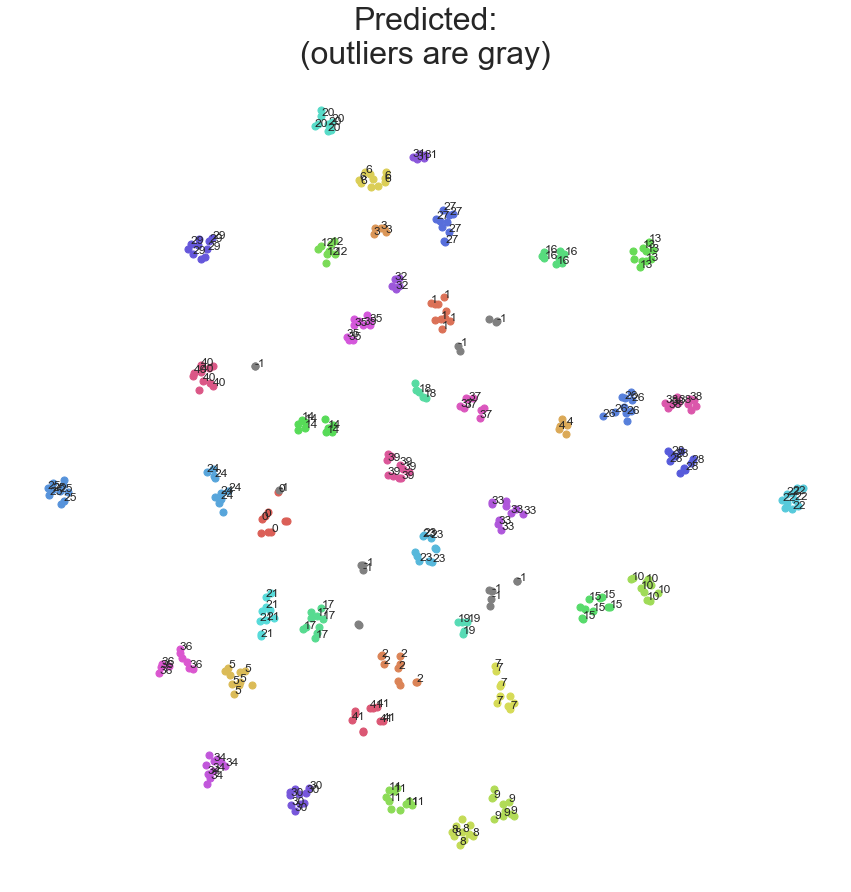

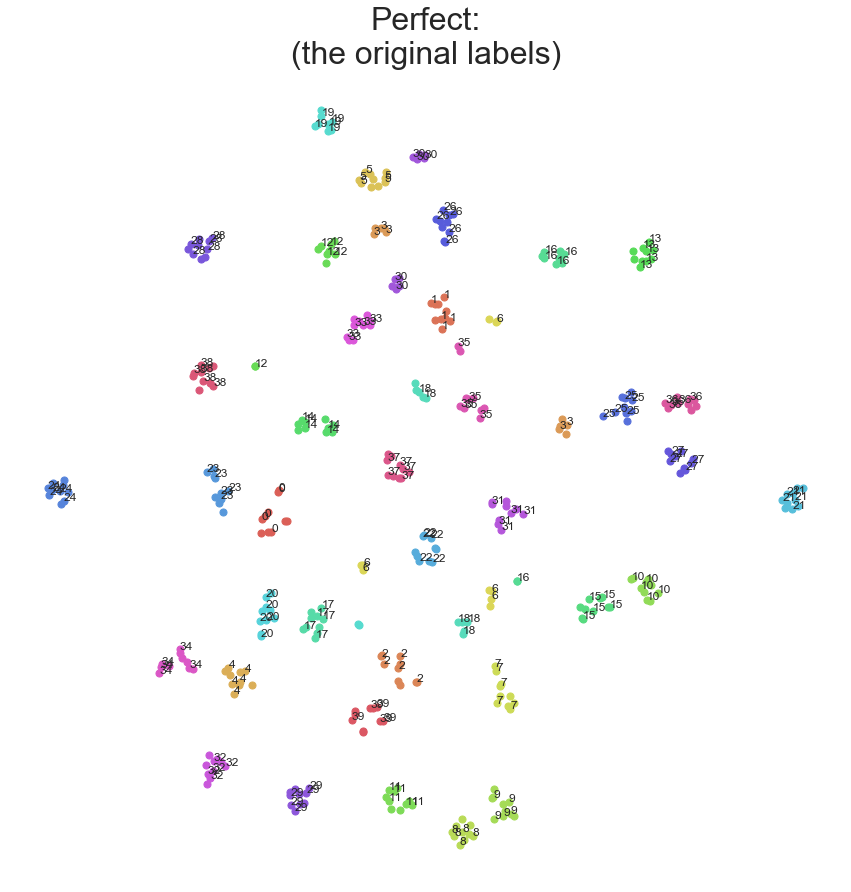


Cluster 0:


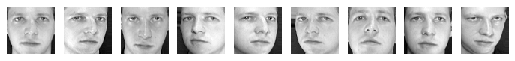

Cluster 1:


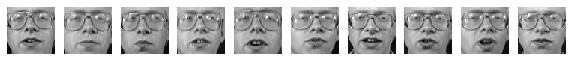

Cluster 2:


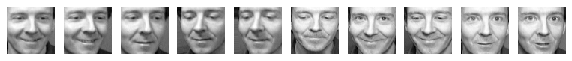

Cluster 3:


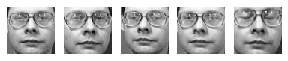

Cluster 4:


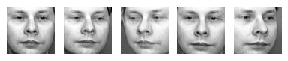

Cluster 5:


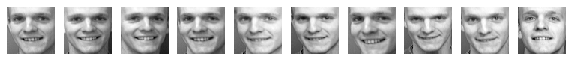

Cluster 6:


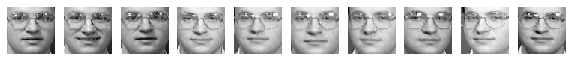

Cluster 7:


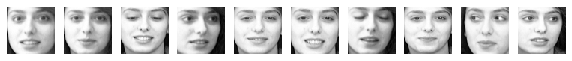

Cluster 8:


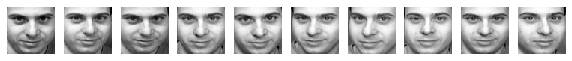

Cluster 9:


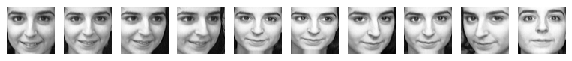

Cluster 10:


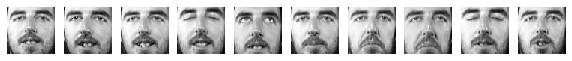

Cluster 11:


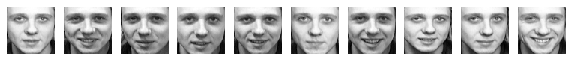

Cluster 12:


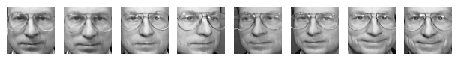

Cluster 13:


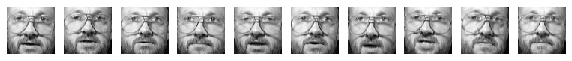

Cluster 14:


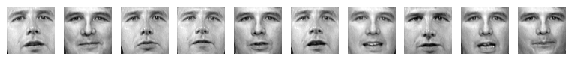

Cluster 15:


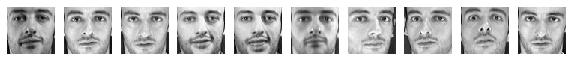

Cluster 16:


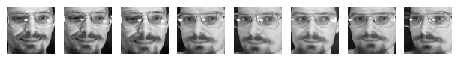

Cluster 17:


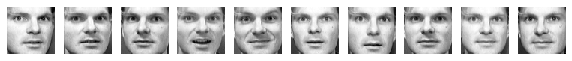

Cluster 18:


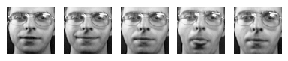

Cluster 19:


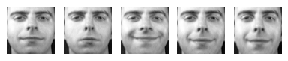

Cluster 20:


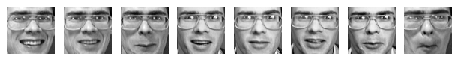

Cluster 21:


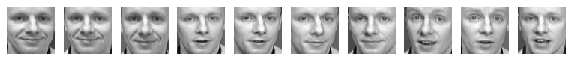

Cluster 22:


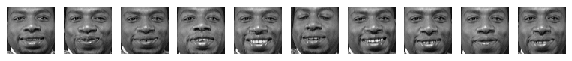

Cluster 23:


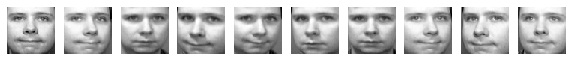

Cluster 24:


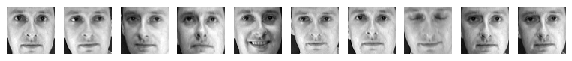

Cluster 25:


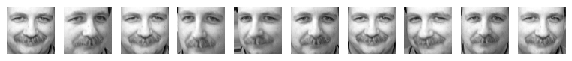

Cluster 26:


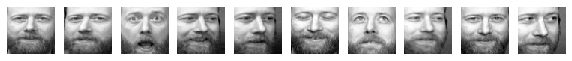

Cluster 27:


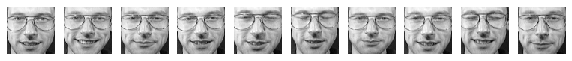

Cluster 28:


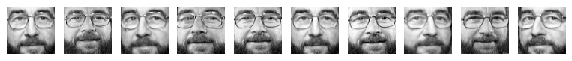

Cluster 29:


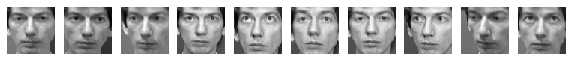

Cluster 30:


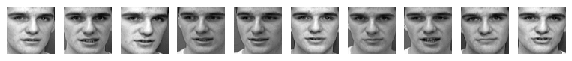

Cluster 31:


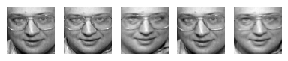

Cluster 32:


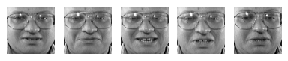

Cluster 33:


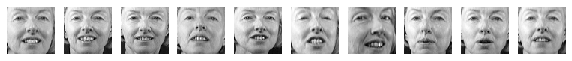

Cluster 34:


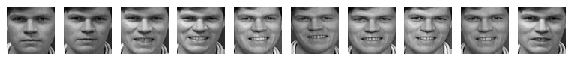

Cluster 35:


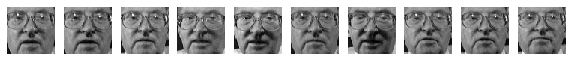

Cluster 36:


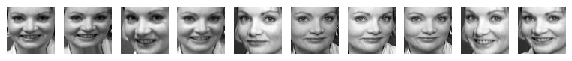

Cluster 37:


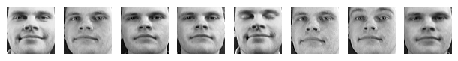

Cluster 38:


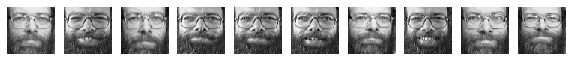

Cluster 39:


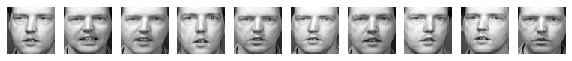

Cluster 40:


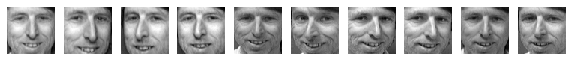

Cluster 41:


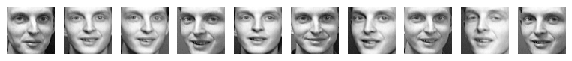

Outliers: 19 out of 400


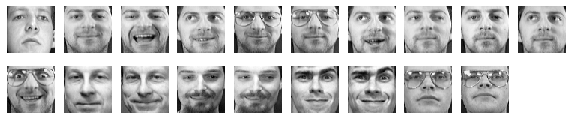

In [11]:
pred = embedder.predict(np.expand_dims(np.array(faces.images), -1))
reduced = TSNE(n_components=2, perplexity=10, n_jobs=-1).fit_transform(pred)
labels = DBSCAN(eps=3.5).fit(reduced).labels_
print("F1 score: "+str(F1Score(faces.target, labels)))
visClustering(reduced, labels, title="Predicted:\n(outliers are gray)")
visClustering(reduced, faces.target, title="Perfect:\n(the original labels)")
drawClusteredImages(labels, faces.images)

Notice that some persons who have images with and without glasses got separated into two different clusters. It is not entirely surprising since the detection algorithm we used had some trouble detecting people who wear glasses. As a result, it is possible that the network did not have the appropriate data that could have helped it learn features that can deal with such differences (it is also possible that the original data was not varied enough in that respect). Other than that, the results are quite satisfactory.

### Create a random subset of the first dataset:

In [22]:
random.shuffle(celebaData)
x_celeb = []
y_celeb = []
for i in range(400):
    for j in range(len(celebaData[i])):
        x_celeb.append(celebaData[i][j])
        y_celeb.append(i)

### Cluster it:

F1 score: 0.8013787546443439



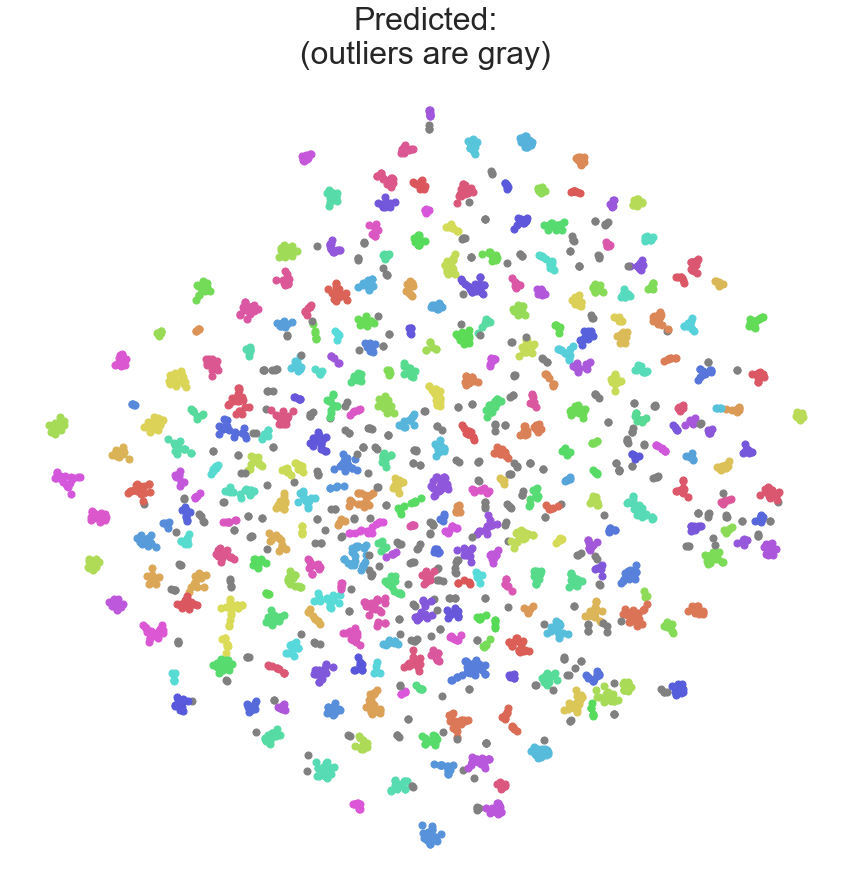

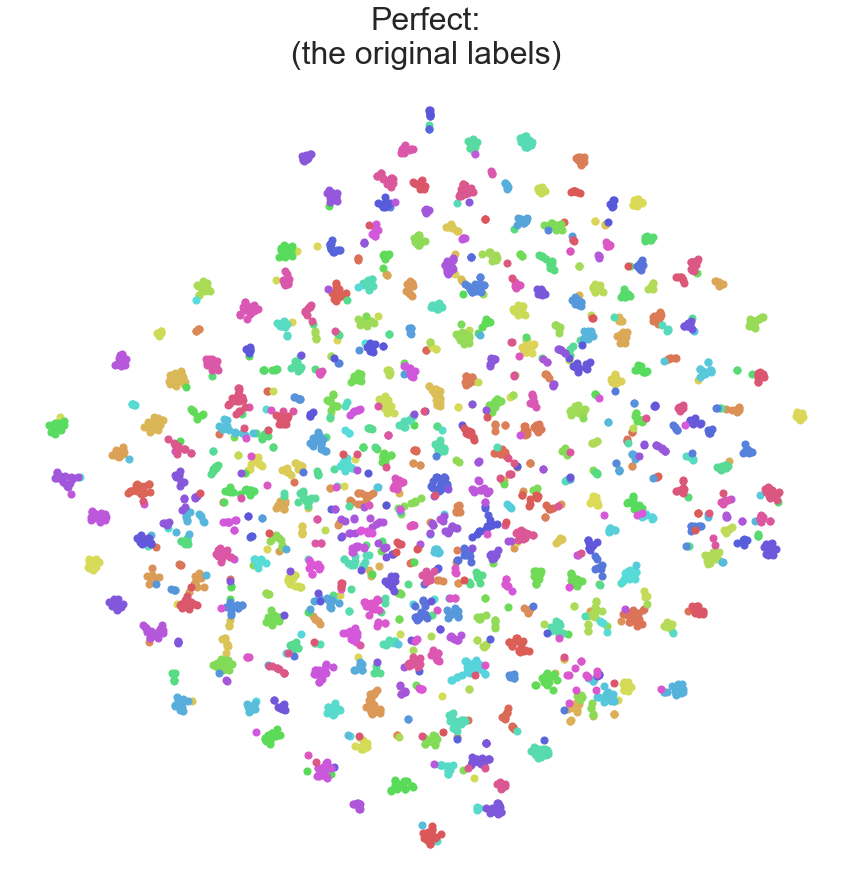

In [24]:
pred = embedder.predict(np.array(x_celeb))
reduced = TSNE(n_components=2, perplexity=10, n_jobs=-1).fit_transform(pred)
labels = DBSCAN(eps=2.0).fit(reduced).labels_
print("F1 score: "+str(F1Score(y_celeb, labels)))
visClustering(reduced, labels, title="Predicted:\n(outliers are gray)", text=False)
visClustering(reduced, y_celeb, title="Perfect:\n(the original labels)", text=False)

Even at a total of ~4,000 images of 400 different individuals, our network did quite well.

### Comparison to existing solutions (see https://pypi.org/project/keras-facenet/): 

### Cluster the third dataset:

F1 score: 1.0



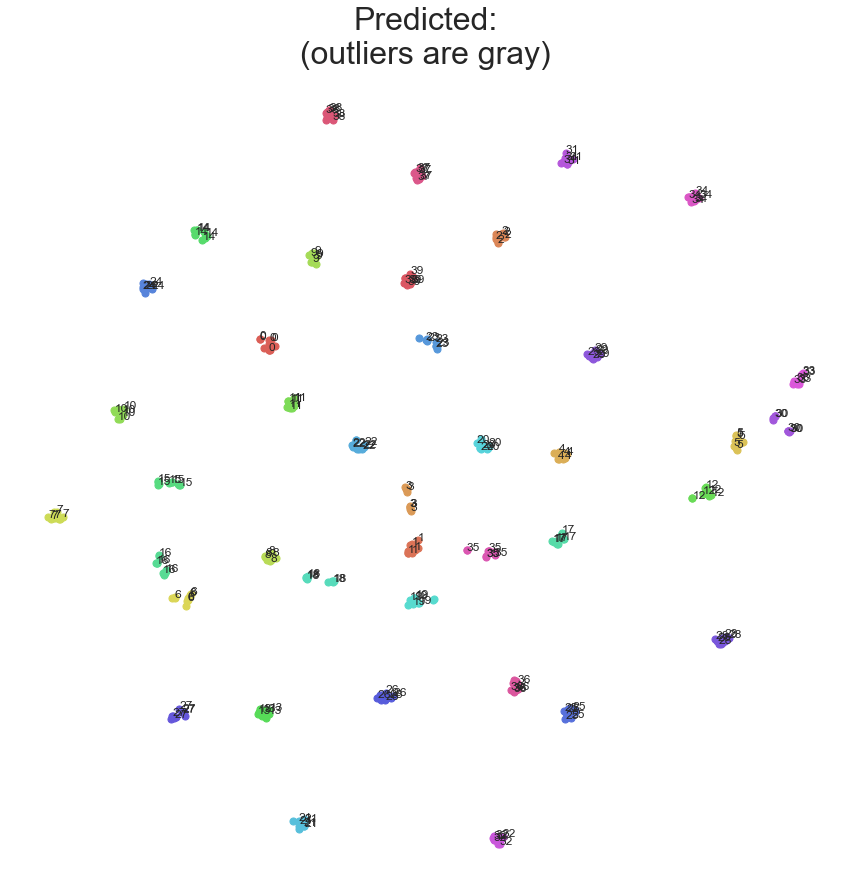

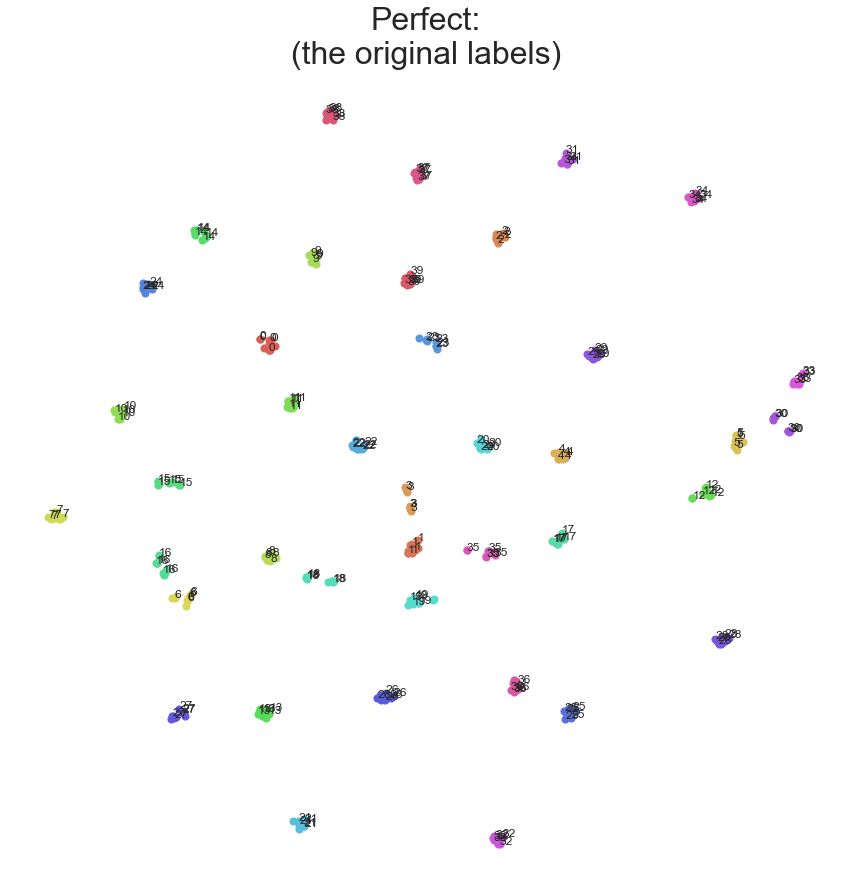

In [25]:
fnEmbedder = FaceNet()
imgs = [cv2.merge((x,x,x)) for x in np.array(faces.images)*255]
pred = fnEmbedder.embeddings(imgs)
reduced = TSNE(n_components=2, perplexity=10, n_jobs=-1).fit_transform(pred)
labels = DBSCAN(eps=3.0).fit(reduced).labels_
print("F1 score: "+str(F1Score(faces.target, labels)))
visClustering(reduced, labels, title="Predicted:\n(outliers are gray)")
visClustering(reduced, faces.target, title="Perfect:\n(the original labels)")

We can see that the image embeddings of every person are nearly condensed to a single point. Quite impressive.

### Cluster the first dataset (random subset):

F1 score: 0.9241225531185009



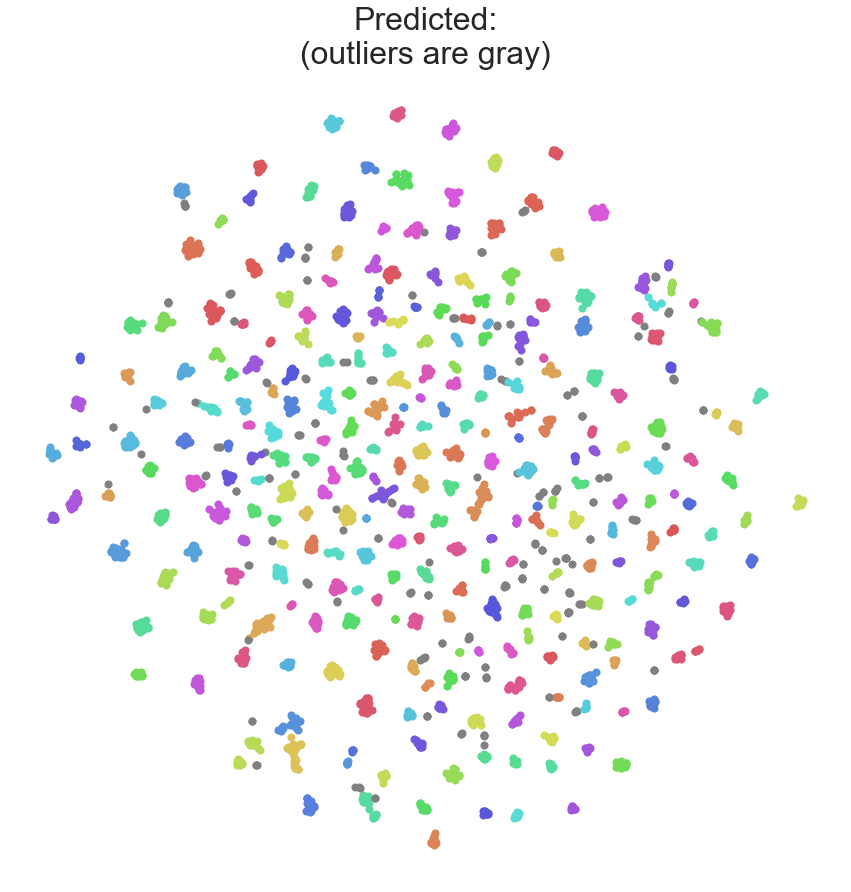

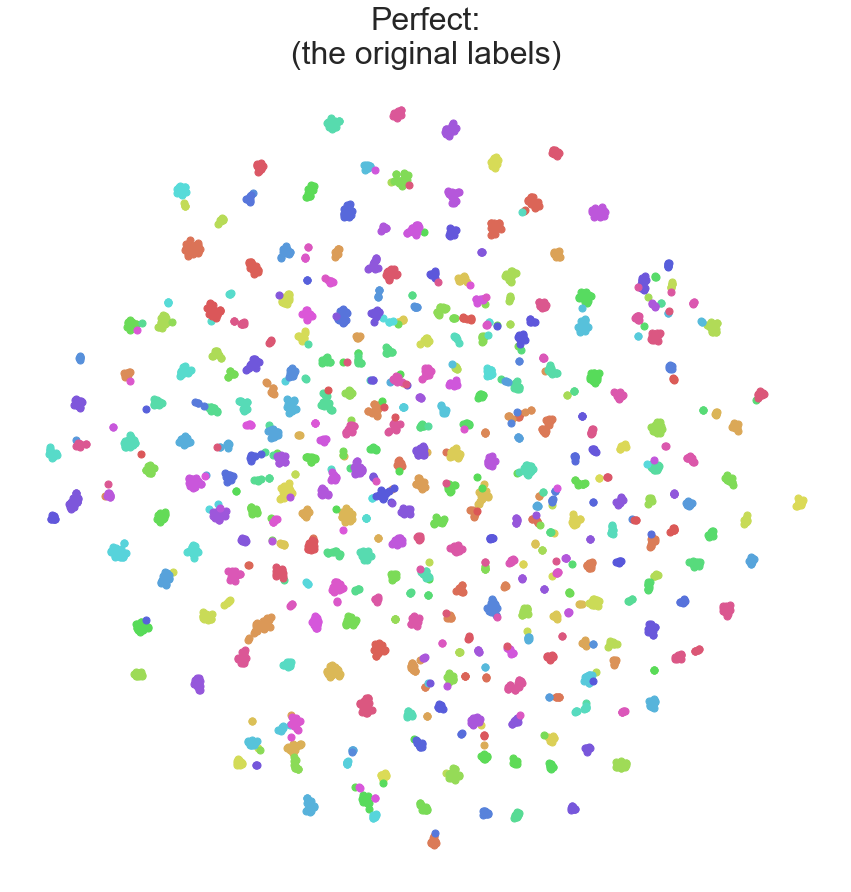

In [26]:
imgs = [cv2.merge((x,x,x)) for x in np.squeeze(np.array(x_celeb))*255]
pred = fnEmbedder.embeddings(imgs)
reduced = TSNE(n_components=2, perplexity=10, n_jobs=-1).fit_transform(pred)
labels = DBSCAN(eps=2.0).fit(reduced).labels_
print("F1 score: "+str(F1Score(y_celeb, labels)))
visClustering(reduced, labels, title="Predicted:\n(outliers are gray)", text=False)
visClustering(reduced, y_celeb, title="Perfect:\n(the original labels)", text=False)

Clearly, this network is capable of handling larger datasets.

### Let us see the results HOG features provide us with on the third dataset (these are the same features we used in our presentation):

F1 score: 0.6911447084233261



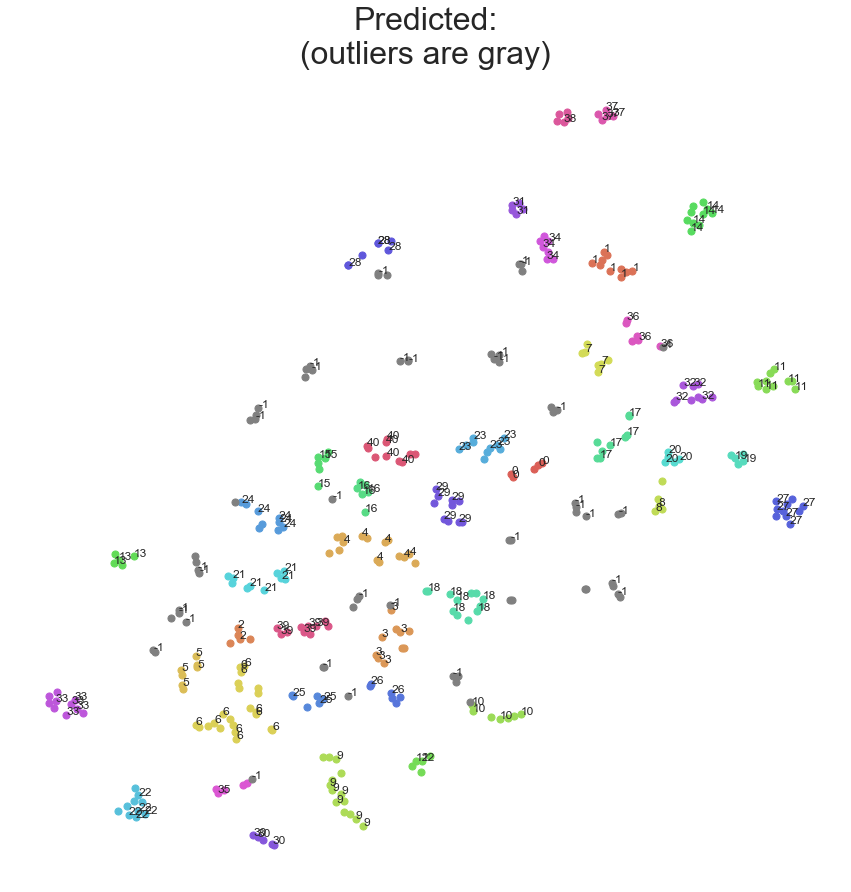

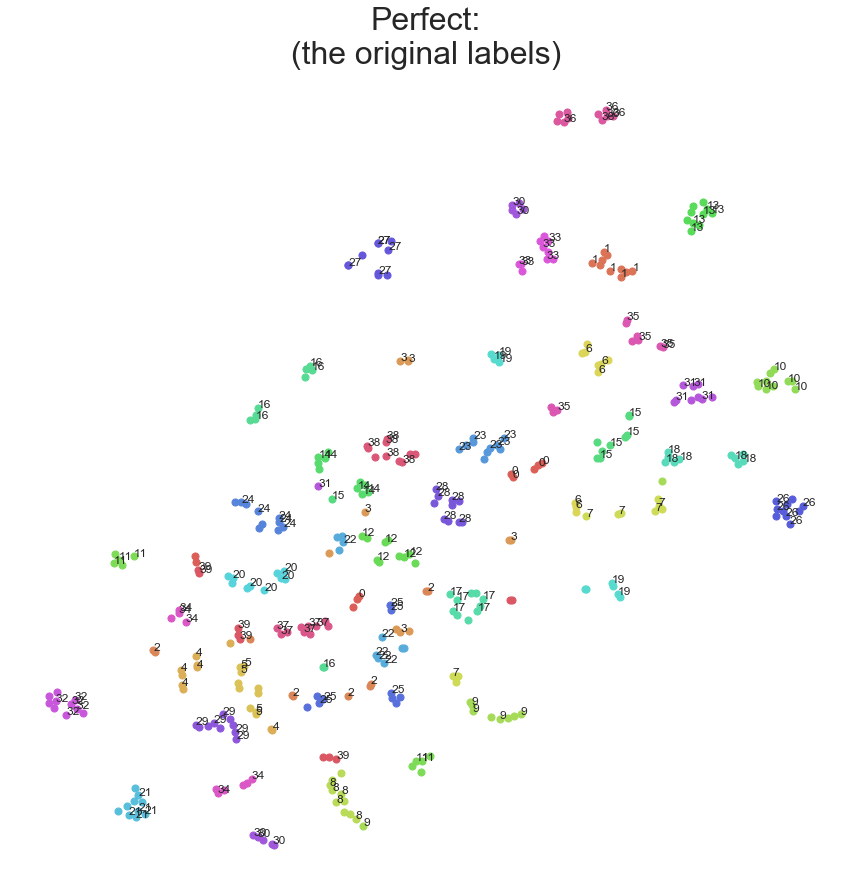

In [27]:
def hog(img):
    b = 8 # bin size
    c = 16 # cell size
    # calc gradients
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=1)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(b*ang/(2*np.pi))
    hist = []
    # concat hists of grads
    for i in range(64//c):
        for j in range(64//c):
            bin_cells = bins[c*i:c*(i+1),c*j:c*(j+1)] # angles
            mag_cells = mag[c*i:c*(i+1),c*j:c*(j+1)] # magnitudes
            hist += [np.bincount(bin_cells.ravel(), mag_cells.ravel(), b)] # concat the next hist   
    return np.hstack(hist) # flatten the hists                  
   
X_hog = np.array([hog(x) for x in faces.images]) # transfrom faces to HOG representations

reduced = TSNE(n_components=2, perplexity=10, n_jobs=-1).fit_transform(X_hog)
labels = DBSCAN(eps=3.5).fit(reduced).labels_
print("F1 score: "+str(F1Score(faces.target, labels)))
visClustering(reduced, labels, title="Predicted:\n(outliers are gray)")
visClustering(reduced, faces.target, title="Perfect:\n(the original labels)")

Not good enough.

### Discussion:

Upon seeing the "Olivetti faces" dataset in the study guide, we started our journey to learn about face clustering and how it can be performed. At first, we took the naive approach - clustering by using traditional computer vision features (e.g. HOG features) and hierarchical clustering techniques (we presented our work to the other students in our presentation). After some brainstorming, we decided to make our project about this very topic, while adding an extra component of face detection to the program as means to obtain images of faces on the ground. We read quite a bit of material online to see what has already been done in this area. In light of what we read, we decided to take up the challenge and learn more about convolutional neural networks, so that we can design a relatively simple model that can produce useful features that help distinguish between faces of different individuals. Initially, we tried to implement a network that performs its task by directly learning similarity (triplet loss). Unfortunately, even though the network succeeded to some degree, we were not happy with the results; it seems that this method requires an exceptionally long training time (the number of valid triplets is cubic in the number of examples) and sophisticated triplet selection\mining methods. Despite that, it was a great lesson in how convolutional neural networks “behave”. Nevertheless, we were not willing to give up and admit to failure (relative to our goals) and we were determined to come up with another strategy (and so we did). We speculated that training the network to classify\recognize faces might result in learning useful features (that can be extracted from the last inner layer). After training the revised network, we proceeded with the clustering stage and, to our great surprise, t-SNE projected the face embeddings (of the third dataset) in neatly organized clusters and the F1 score was well above 0.9 - better than anything we were able to accomplish using the previous network. It is evident that our new network learned features that are useful for distinguishing between faces in the general sense, and it did so within a remarkably short training time as well (it would be interesting to see what can be achieved by using this method with much larger datasets). Having said that, the pretrained network we imported did considerably better than ours, but we are satisfied with the results, nonetheless.

### Conclusions:

First, let us talk about the elephant in the room - it seems that features learned by neural networks put simple traditional computer vision features to shame when it comes to face clustering (and probably many other things as well).
Still, there are times when a simpler solution is more practical and accessible - that is one of the reasons why we used Viola-Jones algorithm to perform the face detection (installing a complex neural network on a simple camera, for instance, might not be feasible). This algorithm certainly has some disadvantages, though. For example, it completely failed to detect side view images. But, on the flip side, this means that our network did not need to be able to generalize as much (provided it only had to deal with images of faces that were detected using this algorithm).<br>
Overall, we were able to achieve good results that exceeded our expectations; it seems that useful features for face recognition (of familiar faces) can be useful for face clustering (of unknown faces) as well.
We could not create something that can compete with state-of-the-art solutions like the one we presented, but that was not our goal, of course (the pretrained network we compared our results to is probably heavily engineered\optimized and was trained on powerful hardware for a much longer time, while learning from a lot more data).

### Appendix:

### This is some of the code for the first network (it worked but we were not satisfied with the results):

In [92]:
# this is the first network that we tried
'''inputShape = trainData[0][0].shape
featVecSize = 512 # output vector size

def CNN(networkDepth, layerDepth, featureMult):
    x = inputs = Input(shape=inputShape)
            
    for i in range(networkDepth): # how deep?
        for j in range(layerDepth): # how many conv2d layers?
            x = layers.Conv2D(2**i*featureMult, 3, activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(featVecSize)(x)
    outputs = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

    return Model(inputs, outputs)

CNN = CNN(networkDepth=3, layerDepth=3, featureMult=32) # the inner network

# display it
display(keras.utils.plot_model(CNN, show_shapes=True))
CNN.summary()

# input and output of the full network (we input 3 images and output 3 feature vectors)
anc_in = Input(shape=inputShape)
pos_in = Input(shape=inputShape)
neg_in = Input(shape=inputShape)
anc_out = CNN(anc_in)
pos_out = CNN(pos_in)
neg_out = CNN(neg_in)

# we train model and predict with trainedModel
model = Model(inputs=[anc_in, pos_in, neg_in], outputs=layers.concatenate([anc_out, pos_out, neg_out]))
trainedModel = Model(inputs=anc_in, outputs=anc_out)

# display the full model
display(keras.utils.plot_model(model, show_shapes=True))
model.summary()

alpha = 0.2 # the alpha in the triplet loss function
beta = 100
epochs = 1 # we run one epoch each time with new random triplets 
batch_size = 32

# calculates loss and accuracy
def helper(y_true, y_pred):
    # get the 3 feature vectors (tensors)
    anc = y_pred[:,0:featVecSize]
    pos = y_pred[:,featVecSize:2*featVecSize]
    neg = y_pred[:,2*featVecSize:3*featVecSize]
    # calc according to the triplet loss function
    distToPos = K.sum(K.square(anc-pos), axis=1)
    distToNeg = K.sum(K.square(anc-neg), axis=1)
    return K.mean(K.maximum(beta * distToPos - distToNeg + alpha, 0), axis=0)

def tripletLoss(y_true, y_pred):
    return helper(y_true, y_pred)

model.compile(optimizer="Adam", loss=tripletLoss)

history = [] # accumulates loss\accuracy values with every iteration
while True:
    try:
        gc.collect() # force gc before generating a lot of triplets
        #generate random triplets
        x_train_anc, x_train_pos, x_train_neg = randomTriplets(trainData, maxExamplesPerClass=2, 
                                                               maxClassNeg=3, maxNegs=3)
        y_dummy = np.empty((len(x_train_anc),3*featVecSize,1)) # we do not use labels so just input dummy
        history.append(model.fit([x_train_anc, x_train_pos, x_train_neg], y_dummy, 
                                 batch_size=batch_size, epochs=epochs, validation_split=0.1))
    except KeyboardInterrupt:
        print("\n\nTraining stopped!")
        break''';

# this method was used to generate random triplets for the first network
'''# this method generates random triplets. every person in the train set is represented as an anchor\positive.
def randomTriplets(data, maxExamplesPerClass, maxClassNeg, maxNegs):
    anchors = []
    positives = []
    negatives = []
    classSelections = []
    generated=0 # triplets generation counter
    for k in range(len(data)): # for every person
        examplesForCurrentClass = min(maxExamplesPerClass, len(data[k])) # how many images per person?
        classSelections.append(np.random.choice(range(len(data[k])), # choose some random images of person k
                                                examplesForCurrentClass, replace=False)) 
        # create all (anchor, positive) permutations of this person's selected images
        for i in range(examplesForCurrentClass): 
            for j in range(examplesForCurrentClass):
                if i != j: # skip the same image (anchor = positive)
                    negClasses = set(range(len(data)))-set([k]) # everyone else
                    randomNegClasses = np.random.choice(list(negClasses), # how many negtive persons? choose randomly
                                                        min(maxClassNeg, len(negClasses)), replace=False) 
                    for n in randomNegClasses: # for each of them:
                        # choose random images of the current negative
                        negs = [data[n][x] for x in np.random.choice(range(len(data[n])),
                                                                     min(maxNegs, len(data[n])), replace=False)]
                        # append the selected triplet
                        for neg in negs:
                            anchors.append(data[k][classSelections[k][i]])
                            positives.append(data[k][classSelections[k][j]])
                            negatives.append(neg)
                            generated+=1
                            if generated % 1000 == 0: # notify the user
                                printOverLine("Generating triplets: "+str(generated))   
    print("Generating triplets: "+str(generated))
    return anchors, positives, negatives'''

# this displays some random triplets
'''a, p, n = randomTriplets(trainData, maxExamplesPerClass=2, maxClassNeg=1, maxNegs=1)
# transfrom back to standard image shape
a = np.squeeze(a)
p = np.squeeze(p)
n = np.squeeze(n)

plt.figure(figsize=(3,10))
for i in range(min(10, len(a))):
    plt.subplot(10, 3, 3*i+1)
    plt.imshow(a[i], cmap='gray')
    plt.axis('off')
    plt.subplot(10, 3, 3*i+2)
    plt.imshow(p[i], cmap='gray')
    plt.axis('off')
    plt.subplot(10, 3, 3*i+3)
    plt.imshow(n[i], cmap='gray')
    plt.axis('off')
plt.show()

del a, p, n # these waste memory so del''';

### This can be used to save\load a model:

In [9]:
#model.save(startPath+"m.hdf5")
#model = keras.models.load_model(startPath+"m.hdf5", compile=False)